# Gaussian processes demonstration

Last revised: 29-Oct-2019 by Dick Furnstahl [furnstahl.1@osu.edu]

Revised: 07-Oct-2019 by Christian Forssén [christian.forssen@chalmers.se]

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid"); sns.set_context("talk")

import GPy    # a Gaussian Process (GP) framework written in python

## Gaussian processes as infinite-dimensional Gaussian distributions
Adapted partly from a tutorial by [Andreas Damianou](http://adamian.github.io/talks/Brown2016.html) (2016).

A Gaussian process (GP) is a collection of random variables, any finite number of which have a joint Gaussian distribution.

Equivalently, a GP can be seen as a stochastic process which corresponds to an infinite dimensional Gaussian distribution.

### Intuition by sampling and plotting multivariate Gaussians

Let's first define some plotting functions that we'll use later. 

In [2]:
def gen_Gaussian_samples(mu, Sigma, N=200):
    """
     Generate N samples from a multivariate Gaussian with mean mu 
      and covariance Sigma.
    """
    D = mu.shape[0]
    samples = np.zeros((N, D)) # N x D array
    for i in np.arange(N):
        samples[i,:] = np.random.multivariate_normal(mean=mu, cov=Sigma)
    return samples.copy()


def gen_plot_Gaussian_samples(mu, Sigma, N=1000):
    """
     Generate N samples from a multivariate Gaussian with mean mu and 
      covariance Sigma and plot the samples as they're generated
    """
    for i in np.arange(N):
        sample = np.random.multivariate_normal(mean=mu, cov=Sigma)
        plt.plot(sample[0], sample[1], '.', color='r', alpha=0.6)


def plot_Gaussian_contours(x, y, mu, Sigma, N=100):
    """
     Plot contours of a 2D multivariate Gaussian based on N points. 
      Points x and y are given for the limits of the contours.
    """
    X, Y = np.meshgrid(np.linspace(x.min()-0.3, x.max()+0.3,100), 
                       np.linspace(y.min()-0.3, y.max()+0.3,N) )
    rv = multivariate_normal(mu, Sigma)
    Z = rv.pdf(np.dstack((X, Y)))
    plt.contour(X, Y, Z)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')

def plot_sample_dimensions(samples, colors=None, markers=None, ms=10):
    """
     Given a set of samples from a bivariate Gaussian, plot them, 
      but instead of plotting them x1 vs x2, plot them as 
      [x1 x2] vs ['1', '2'].
    """
    N = samples.shape[0]
    D = samples.shape[1]
    
    t=np.array(range(1,D+1))

    for i in np.arange(N):
        if colors is None and markers is None:
            plt.plot(t,samples[i,:], '-o', ms=ms)
        elif colors is None:
            plt.plot(t,samples[i,:], '-o', marker=markers[i], ms=ms)
        elif markers is None:
            plt.plot(t,samples[i,:], '-o', color=colors[i], ms=ms)
        else:
            plt.plot(t,samples[i,:], '-o',color=colors[i],
                     marker=markers[i], ms=ms)
            
    plt.xlim([0.8,t[-1]+0.2])
    plt.ylim([samples.min()-0.3, samples.max()+0.3])
    plt.xlabel('d = {' + str(t) + '}')
    plt.ylabel(r'$x_d$')
    plt.gca().set_title(str(N) + ' samples from a bivariate Gaussian')


def set_limits(samples):
    """
     Pad the limits so extend beyond minimum and maximum of samples.
    """
    plt.xlim([samples[:,0].min()-0.3, samples[:,0].max()+0.3])
    plt.ylim([samples[:,1].min()-0.3, samples[:,1].max()+0.3])

#### Review of bivariate normal case

$\newcommand{\xvec}{\textbf{x}}$
$\newcommand{\muvec}{\boldsymbol{\mu}}$
The general multivariate Gaussian distribution is

$$
 p(\xvec\mid \muvec,\Sigma) = \frac{1}{\sqrt{\det(2\pi\Sigma)}} e^{-\frac12(\xvec-\muvec)^{\rm T}\Sigma^{-1}(\xvec-\muvec)}
$$

For the *bivariate* case we can parameterize the mean vector and covariance matrix as

$$
  \muvec = \left( \begin{array}{c}
                     \mu_x \\ \mu_y
                  \end{array}       \right)
    \;, \qquad
  \Sigma = \left( \begin{array}{cc}
                    \sigma_x^2 & \rho\sigma_x\sigma_y \\
                    \rho\sigma_x\sigma_y & \sigma_y^2
                  \end{array}
           \right)  
$$

The covariance matrix must be positive definite, which implies $\color{red}{0\lt\rho^2\lt 1}$.

If take $\mu_x = \mu_y = 0$ and $\sigma_x = \sigma_y = \sigma$ for clarity,
so that

$$
  \Sigma = \sigma^2 \left(\begin{array}{cc}
                       1 & \rho \\
                       \rho & 1
                       \end{array}
                    \right)
$$

and

$$
  p(x,y\mid \sigma,\rho) = \frac{1}{2\pi\sigma^2} 
        \exp\left(-\frac{x^2 + y^2 - 2\rho x y }{2\sigma^2\sqrt{1-\rho^2}}    
          \right)
          \;.
$$

It's clear that contours of equal probability have $x^2 + y^2 - 2\rho xy = \mbox{constant}$, so they are ellipses.  The value of $\rho$ determines the eccentricity of the ellipse.
If $\rho=0$, $x$ and $y$ are independent (uncorrelated) and we have a circle.  As $\rho$ approaches $+1$, $x$ and $y$ are increasingly correlated (toward straight line at $45^\circ$), while for $\rho$ approaching $-1$ they become increasingly anti-correlated (toward straight line at $-45^\circ$).

For reference, the Cholesky decomposition of $\Sigma$ is

$$
  \Sigma = \sigma^2\left( \begin{array}{cc}
                    1 & \rho \\
                    \rho & 1
                  \end{array}
           \right)
           =
           \sigma^2\left( \begin{array}{cc}
                    1 & 0 \\
                    \rho &  \sqrt{1-\rho^2}
                  \end{array}
           \right)  
           \left( \begin{array}{cc}
                    1 & \rho \\
                    0 &  \sqrt{1-\rho^2}
                  \end{array}
           \right)  
$$


Test two different ways of plotting a bivariate Gaussian.

 /var/folders/_s/v5m4jp4x2y332nzvt9zn1qxr0000gn/T/ipykernel_26146/1333663173.py:19: UserWarning:marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
 /var/folders/_s/v5m4jp4x2y332nzvt9zn1qxr0000gn/T/ipykernel_26146/3005440237.py:55: UserWarning:marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
 /var/folders/_s/v5m4jp4x2y332nzvt9zn1qxr0000gn/T/ipykernel_26146/3005440237.py:55: UserWarning:marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
 /var/folders/_s/v5m4jp4x2y332nzvt9zn1qxr0000gn/T/ipykernel_26146/3005440237.py:55: UserWarning:marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
 /var/folders/_s/v5m4jp4x2y33

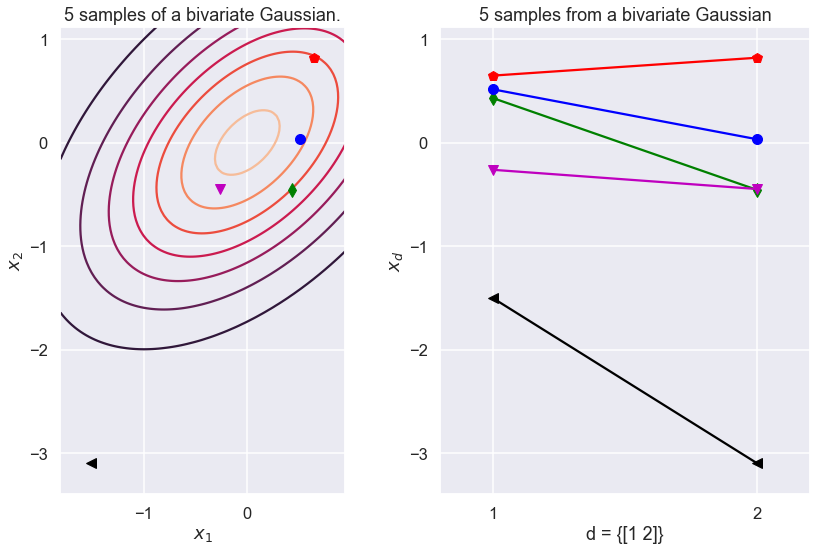

In [3]:
colors = ['r','g','b','m','k']
markers = ['p','d','o','v','<']

N = 5 # Number of samples
mu = np.array([0,0])  # Mean of the 2D Gaussian
sigma = np.array([[1, 0.5], [0.5, 1]]); # covariance of the Gaussian

# Generate samples
np.random.seed()
samples = gen_Gaussian_samples(mu, sigma, N) 

f = plt.figure(figsize=(12,8)); 
ax1 = plt.subplot(1, 2, 1, autoscale_on=True, aspect='equal')
#set_limits(samples)
plot_Gaussian_contours(samples[:,0], samples[:,1], mu, sigma)

# Plot samples
for i in np.arange(N):
    plt.plot(samples[i,0], samples[i,1], 'o', color=colors[i], 
             marker=markers[i], ms=10)
plt.gca().set_title(f'{N} samples of a bivariate Gaussian.')

ax2 = plt.subplot(1, 2, 2, autoscale_on=True)  #, aspect='equal')
ax2.set_xticks([1,2])
plot_sample_dimensions(samples=samples, colors=colors, markers=markers)

plt.tight_layout()

Repeat as before, but now we'll plot many samples from two kinds of Gaussians: one with strongly correlated dimensions and one with weak correlations

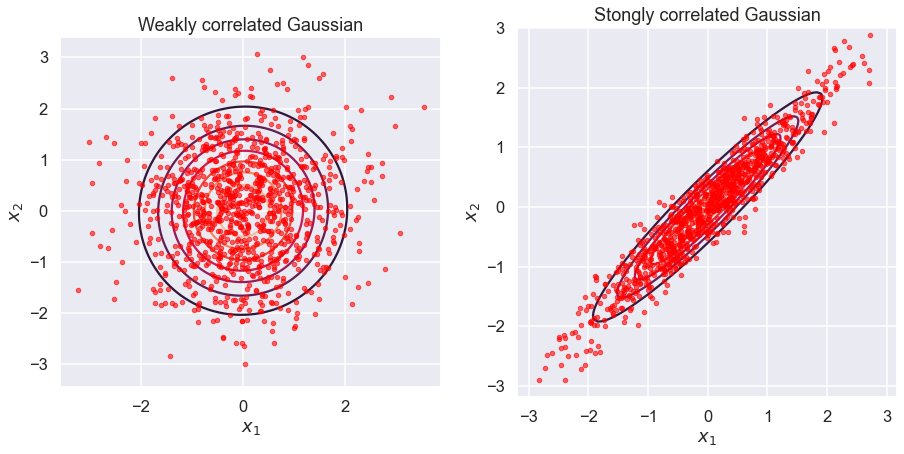

In [4]:
# Plot with contours. Compare a correlated vs almost uncorrelated Gaussian

sigmaUncor = np.array([[1, 0.02], [0.02, 1]]);
sigmaCor = np.array([[1, 0.95], [0.95, 1]]);

f = plt.figure(figsize=(15,15)); 

ax = plt.subplot(1, 2, 1); ax.set_aspect('equal')
samplesUncor=gen_Gaussian_samples(mu, sigmaUncor)
plot_Gaussian_contours(samplesUncor[:,0], samplesUncor[:,1], mu, sigmaUncor)
gen_plot_Gaussian_samples(mu, sigmaUncor)
ax.set_title('Weakly correlated Gaussian')

ax=plt.subplot(1, 2, 2); ax.set_aspect('equal')
samplesCor=gen_Gaussian_samples(mu,sigmaCor)
plot_Gaussian_contours(samplesCor[:,0], samplesCor[:,1], mu, sigmaCor)
gen_plot_Gaussian_samples(mu, sigmaCor)
ax.set_title('Stongly correlated Gaussian');

But let's plot them as before dimension-wise...

> Which one is which?

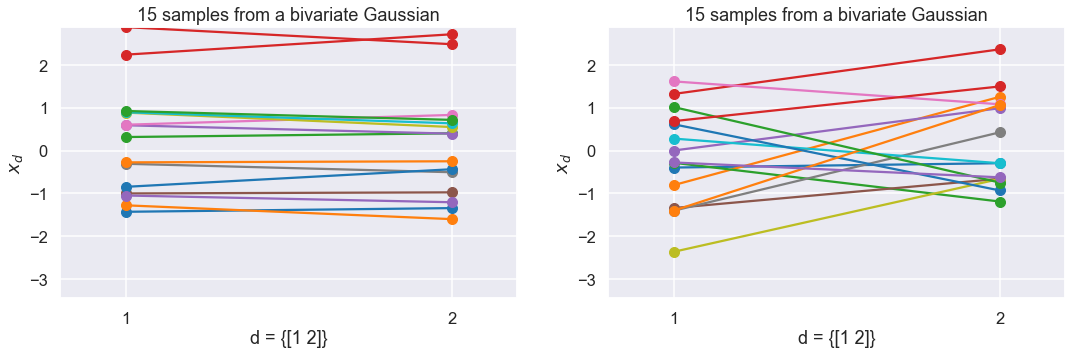

In [5]:
f=plt.figure(figsize=(18,5)); 
perm = np.random.permutation(samplesUncor.shape[0])[0::14]

ax1=plt.subplot(1, 2, 2); ax1.set_aspect('auto')
plot_sample_dimensions(samplesUncor[perm,:])
ax2=plt.subplot(1, 2, 1,sharey=ax1); ax2.set_aspect('auto')
plot_sample_dimensions(samplesCor[perm,:])
if False:
    ax1.set_title('Weakly correlated');
    ax2.set_title('Strongly correlated')
for ax in [ax1,ax2]:
    ax.set_xticks([1,2])
plt.ylim([samplesUncor.min()-0.3, samplesUncor.max()+0.3]);

* The strongly correlated Gaussian gives more "horizontal" lines in the dimension-wise plot.

* More importantly, by using the dimension-wise plot, we are able to plot Gaussians which have more than two dimensions. Below we plot N samples from a D=8-dimensional Gaussian. 

* Because I don't want to write down the full 8x8 covariance matrix, I define a "random" one through a mathematical procedure that is guaranteed to give me back a positive definite and symmetric matrix (i.e. a valid covariance). More on this later.

Covariance matrix:
[[ 5.01  5.01  5.02  5.02  5.02  5.02  5.02  5.02]
 [ 5.01  6.01  6.84  7.27  7.4   7.51  8.07  8.31]
 [ 5.02  6.84  8.72  9.78 10.12 10.41 11.98 12.69]
 [ 5.02  7.27  9.78 11.28 11.76 12.18 14.46 15.5 ]
 [ 5.02  7.4  10.12 11.76 12.3  12.75 15.28 16.44]
 [ 5.02  7.51 10.41 12.18 12.75 13.25 15.99 17.25]
 [ 5.02  8.07 11.98 14.46 15.28 15.99 19.97 21.82]
 [ 5.02  8.31 12.69 15.5  16.44 17.25 21.82 23.96]]
Eigenvalues should be all larger than zero:
[9.29714969e+01 6.85017040e+00 6.32875461e-01 2.01118726e-02
 5.02930468e-03 5.00000000e-03 5.00000000e-03 5.00000000e-03]


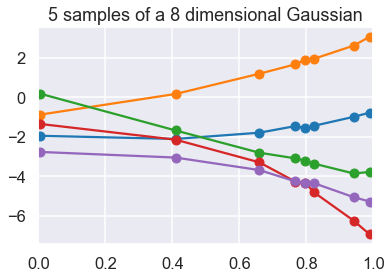

In [6]:
N=5
mu = np.array([0,0,0,0,0,0,0,0])
D = mu.shape[0]

# Generate random covariance matrix
x_pts = np.sort(sp.random.rand(D))[:,None]  
tmp2 = x_pts**np.arange(5)
sigma = 5*np.dot(tmp2, tmp2.T) + 0.005*np.eye(D)
with np.printoptions(precision=2, suppress=True):
    print('Covariance matrix:')
    print(sigma)

print('Eigenvalues should be all larger than zero:')
print(np.linalg.eigvals(sigma))
        
# Now the samples are from a multivariate Gaussian with dimension D
samples = gen_Gaussian_samples(mu, sigma, N)

for i in np.arange(N):
    plt.plot(x_pts, samples[i,:], '-o')

plt.gca().set_xlim(0., 1.)
plt.gca().set_title(f'{N} samples of a {D} dimensional Gaussian');

So each sample has 8 values, which we associate with the 8 x points:

In [7]:
print('x points: ', x_pts)

x points:  [[0.0049217 ]
 [0.4095765 ]
 [0.65971939]
 [0.76661656]
 [0.79710588]
 [0.8219863 ]
 [0.94194822]
 [0.98925593]]


Taking this even further, we can plot samples from a 200-dimensional Gaussian in the dimension-wise plot. 

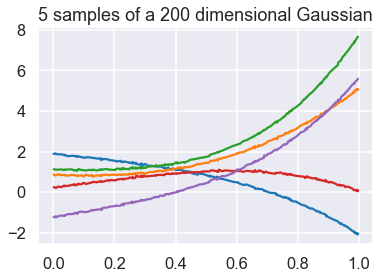

In [8]:
N=5
D=200
mu = np.zeros((D,1))[:,0]

# Generate random covariance matrix
x_pts = np.sort(sp.random.rand(D))[:,None]
tmp2 = x_pts**np.arange(5)
sigma = 5*np.dot(tmp2,tmp2.T)+ 0.0005*np.eye(D)

samples = gen_Gaussian_samples(mu,sigma,N)

for i in np.arange(N):
    plt.plot(x_pts, samples[i,:], '-')

plt.gca().set_title(f'{N} samples of a {D} dimensional Gaussian');

We see that each sample now starts looking like a "smooth" curve (notice that the random variables are highly correlated). Therefore, we now have a clear intuition as to why a GP can be seen as an *infinite dimensional multivariate Gaussian* which is used as a *prior over functions*, since one sample from a GP is a function.

### Covariance functions, aka kernels

We'll see below that the covariance function is what encodes our assumption about the GP. By selecting a covariance function, we are making implicit assumptions about the shape of the function we wish to encode with the GP, for example how smooth it is.

Even if the covariance function has a parametric form, combined with the GP it gives us a nonparametric model. In other words, the covariance function is specifying the general properties of the GP function we wish to encode, and not a specific parametric form for it.

Here we define two very common covariance functions: The RBF (also known as Exponentiated Quadratic or Gaussian kernel) which is differentiable infinitely many times (hence, very smooth),

$$
k_{RBF}(\mathbf{x}_{i},\mathbf{x}_{j}) = \sigma^2 \exp \left( -\frac{1}{2\ell^2} \sum_{q=1}^Q (x_{i,q} - x_{j,q})^2\right)
$$

where $Q$ denotes the dimensionality of the input space. Its parameters are: the *lengthscale* $\ell$ and the variance $\sigma^2$. 

The other covariance function is the Linear kernel:
$$
k_{lin}(\mathbf{x}_{i},\mathbf{x}_{j}) = \sigma^2 \mathbf{x}_{i}^T \mathbf{x}_{j}
$$



Here are some examples with different "kernels" and different parameters that 
dictate those features (figure from J. Melendez):

<img src="../../_images/gp_kernel_realizations.png" width="600" >


#### The RBF kernel (a.k.a Gaussian)

In [9]:
def cov_RBF(x, x2=None, theta=np.array([1,1])):        
        """
         Compute the Euclidean distance between each row of X and X2, 
          or between each pair of rows of X if X2 is None and feed it 
          to the kernel.
         The variance and lengthscale are taken to be unity if not passed. 
        """
        variance = theta[0]
        lengthscale = theta[1]
        if x2 is None:
            xsq = np.sum(np.square(x),1)
            r2 = -2.*np.dot(x,x.T) + (xsq[:,None] + xsq[None,:])
            r = np.sqrt(r2) / lengthscale
        else:
            x1sq = np.sum(np.square(x),1)
            x2sq = np.sum(np.square(x2),1)
            r2 = -2.*np.dot(x, x2.T) + x1sq[:,None] + x2sq[None,:]
            r = np.sqrt(r2) / lengthscale

        return variance * np.exp(-0.5 * r**2)

Given hyperparameters $\theta$, we plot the resulting covariance matrix and samples from a GP with this covariance function.

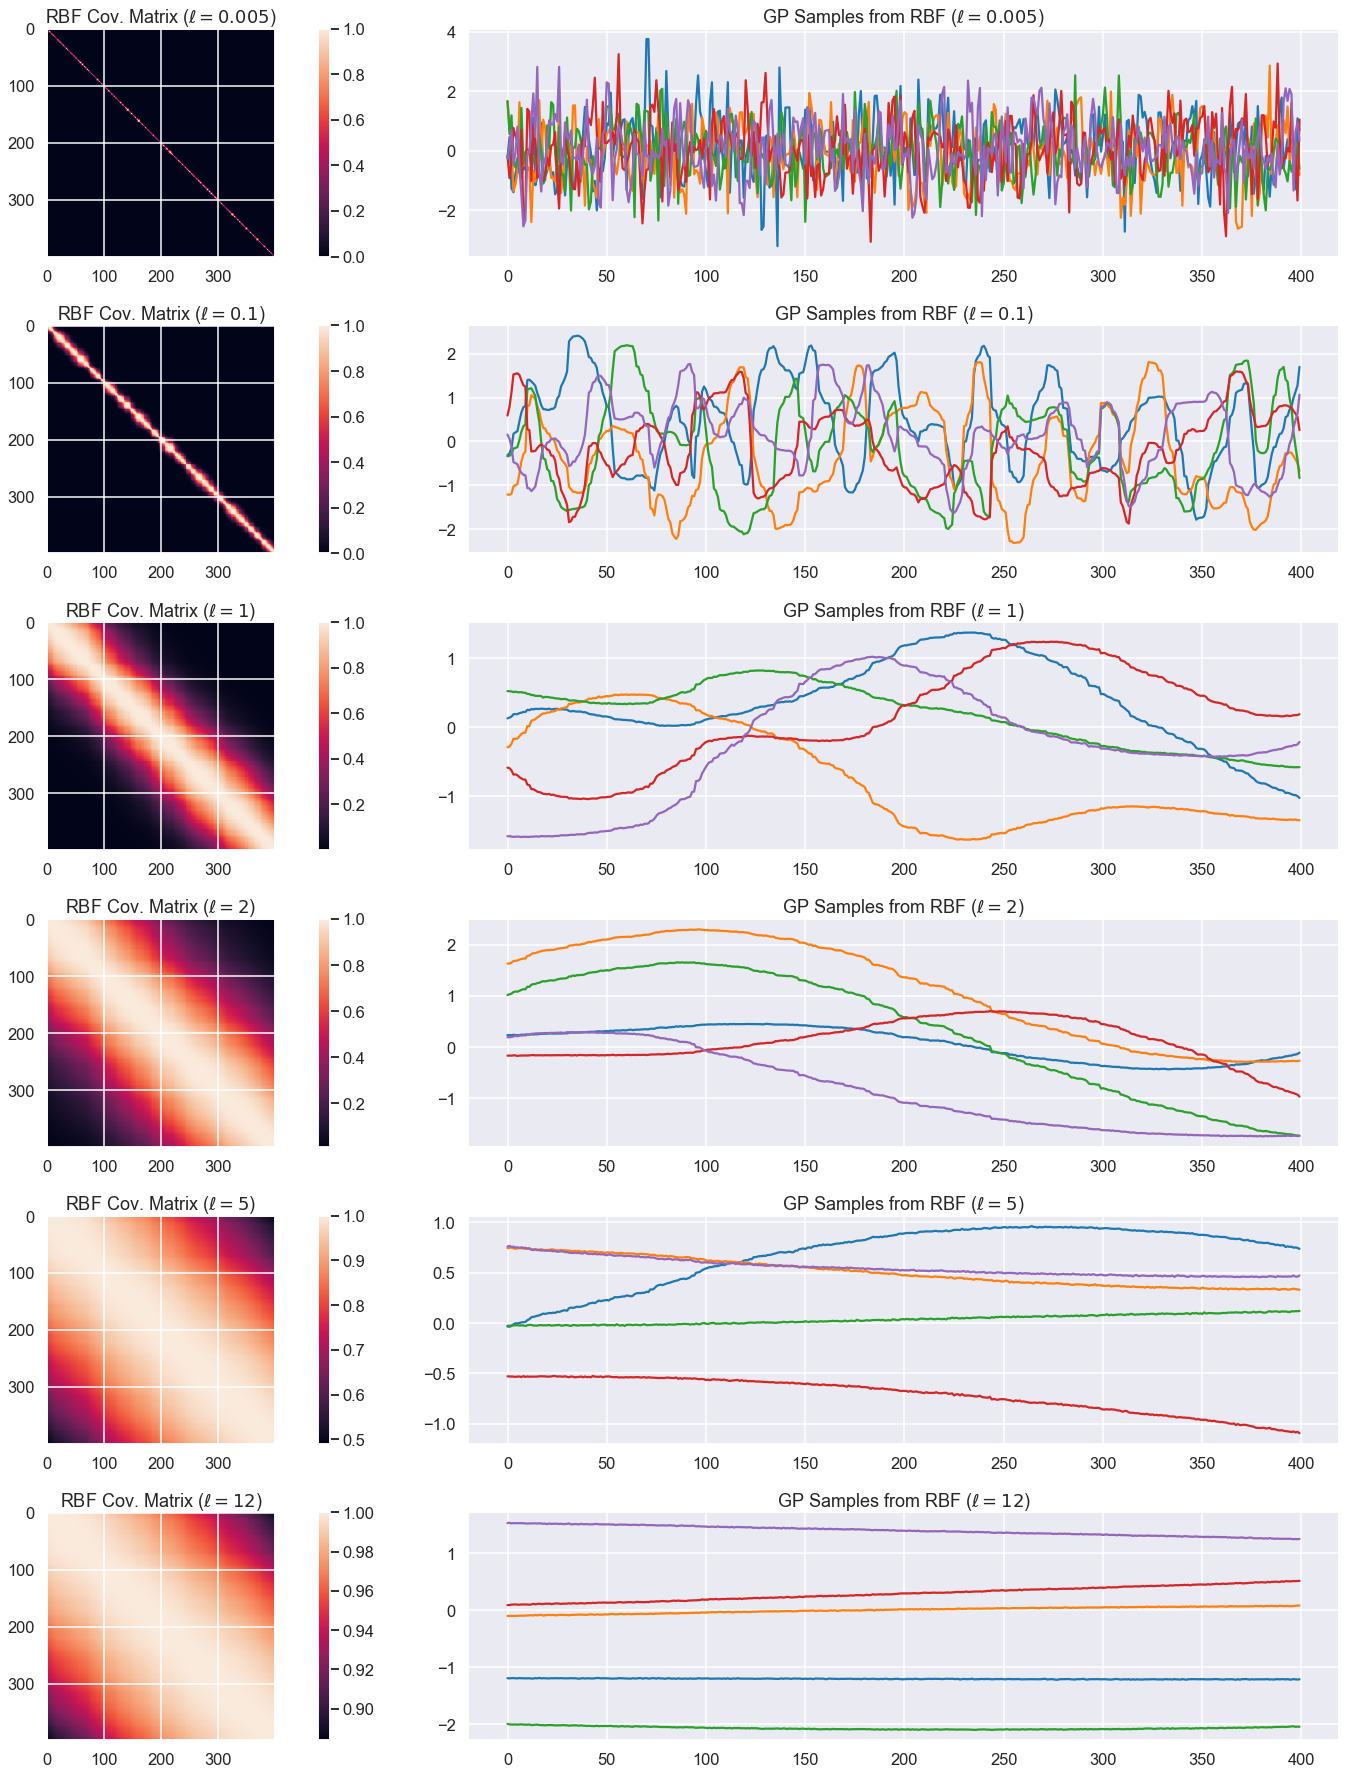

In [10]:
X = np.sort(np.random.rand(400, 1) * 6 , axis=0)

ell_rbf = [0.005, 0.1, 1, 2, 5, 12]  # length scale for RBF
K = len(ell_rbf)

num_samples=5
plt.figure(figsize=(25,25))
j=1
for i in range(K):
    plt.subplot(K,2,j)
    K_rbf = cov_RBF(X, X, theta=np.array([1, ell_rbf[i]]))
    plt.imshow(K_rbf)
    plt.colorbar()
    plt.gca().set_title(rf'RBF Cov. Matrix ($\ell={ell_rbf[i]}$)')
    
    plt.subplot(K, 2, j+1)
    # Assume a GP with zero mean
    mu=np.zeros((1,K_rbf.shape[0]))[0,:]
    for s in range(num_samples):
        # Jitter is a small noise addition to the diagonal elements 
        #  to ensure positive definiteness. Also called a nugget.
        jitter = 1e-5*np.eye(K_rbf.shape[0])
        sample = np.random.multivariate_normal(mean=mu, cov=K_rbf+jitter)
        plt.plot(sample)
    plt.gca().set_title(rf'GP Samples from RBF ($\ell={ell_rbf[i]}$)')
    j+=2
    
plt.tight_layout()

## Example: GP models for regression
### No-core shell model $\hbar\omega$ dependence

In [11]:
# import some NCSM data from
# Phys. Rev. C 97, 034328 (2018)
(E, Nmax, hw) = np.loadtxt('Li6E_NNLOopt_Nmax10.txt', unpack=True)

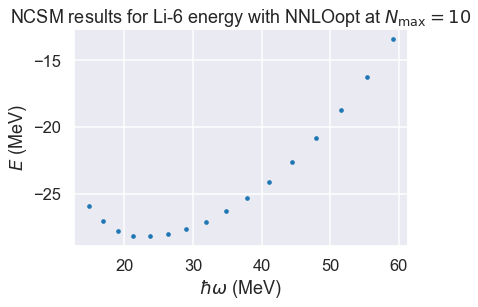

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_ylabel(r'$E$ (MeV)');
ax.set_xlabel(r'$\hbar\omega$ (MeV)');
plot_title = r'NCSM results for Li-6 energy with NNLOopt ' + \
             r'at $N_\mathrm{max}=10$'
ax.set_title(plot_title)
ax.scatter(hw, E, s=10);

GP_regression.,value,constraints,priors
rbf.variance,2.7334831243366655,+ve,
rbf.lengthscale,15.493754387168465,+ve,
Gaussian_noise.variance,3.9116924072201616e-10,+ve,


Validation result: Ratio true/predict in [0.998527,1.004752]


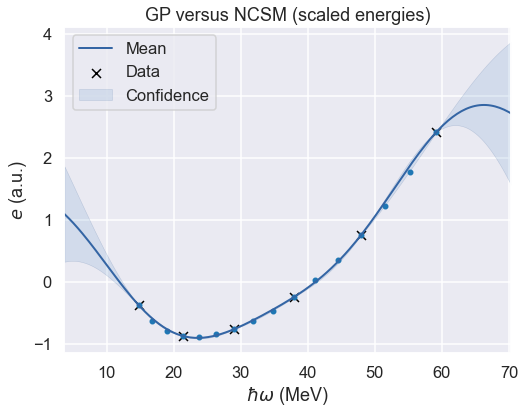

In [25]:
# We will test our GP by training on every third data point and validate on the rest.
# We will print the largest ratios (predict-true)/predict for the interpolate region.
ratio_min = 1.
ratio_max = 1.

x = hw

# Remove the mean and scale the data by its standard deviation.
#  This defines the y values we will model with a GP.
mE = np.mean(E)
sE = np.std(E)
y = (E - mE)/sE

# Training data (xt, yt) is every 3rd point
xt = x[::3, np.newaxis]
yt = y[::3, np.newaxis]

# Define the kernel and fit the hyperparameters
kernel = GPy.kern.RBF(input_dim=1, variance=5., lengthscale=10.)
m = GPy.models.GPRegression(xt, yt, kernel)
m.optimize(messages=False)
display(m)

# Data to predict
xp = x[:, np.newaxis]
yp, vp = m.predict(xp)

#m.optimize()
fig, ax = plt.subplots(figsize=(8,6))
#ax.plot(Xtrue, Ytrue, color='red', alpha=0.5)
m.plot(ax=ax)
#print(m)

for i,yi in enumerate(yp):
    ratio_min=min(ratio_min,np.abs((y[i]+mE)/(yi+mE)))
    ratio_max=max(ratio_max,np.abs((y[i]+mE)/(yi+mE)))
# fig = m.plot(plot_density=True, figsize=(8,6))
# ax=plt.gca()
ax.scatter(hw, (E-mE)/sE, s=20);
ax.set(xlabel=r'$\hbar\omega$ (MeV)', ylabel=r'${e}$ (a.u.)')
ax.set_title(r'GP versus NCSM (scaled energies)')
print('Validation result: Ratio true/predict in [%8.6f,%8.6f]' \
       %(ratio_min, ratio_max))

In [29]:
print(f'{ratio_min[0]:8.6f}')

0.998527
